# Food 101 Full Project

In this notebook i will try a couple of experiments!

Based on DeepFood (Deep Learning-based Food Image
Recognition for Computer-aided Dietary Assessment) the top accuracy is 77.4%, which i will try to beat by using efficientnetb0 architecture: https://arxiv.org/ftp/arxiv/papers/1606/1606.05675.pdf

Hardware used to train: \
    - GPU: RTX 3080 12GB \
    - CPU: Ryzen 5 3600 \
    - RAM: 16GB

## Import the libraries and get the data 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random

In [2]:
# Check if i am using GPU
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
source_folder = 'C:\\Users\\Sooka\\Desktop\\Food101\\food-101\\images'
train_dir = "C:\\Users\\Sooka\\Desktop\\Food101\\food-101\\train"
test_dir = "C:\\Users\\Sooka\\Desktop\\Food101\\food-101\\test"


In [47]:
import os
import shutil


for food in os.listdir(source_folder):
    try:
        os.mkdir(os.path.join(train_dir, food))
        os.mkdir(os.path.join(test_dir, food))
    except FileExistsError:
        print("The folders are already created")

    food_dir = os.path.join(source_folder, food)
    images = os.listdir(food_dir)
    train = images[:750]
    test = images[750:1000]

    for image in train:
        src = os.path.join(food_dir, image)
        dst = os.path.join(train_dir, food, image)
        shutil.copy(src, dst)

    for image in test:
        src = os.path.join(food_dir, image)
        dst = os.path.join(test_dir, food, image)
        shutil.copy(src, dst)


## Visualize and preprocess

In [4]:
class_names = []
for food in os.listdir(train_dir):
    class_names.append(food)
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

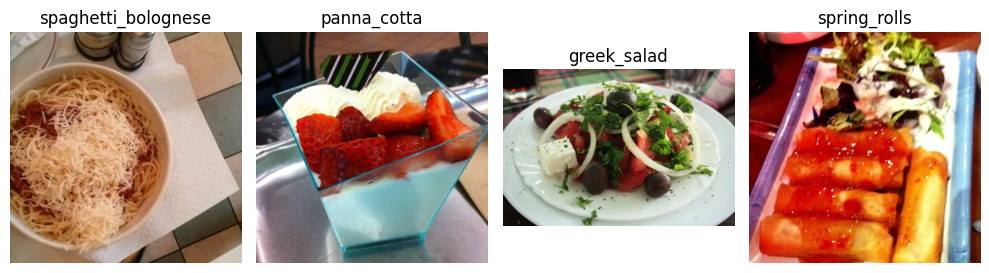

In [5]:
fig = plt.figure(figsize=(10, 7))

total_images = 4

for i in range(total_images):
    random_class = random.choice(class_names)
    class_dir = os.path.join(test_dir, random_class)
    random_image = random.choice(os.listdir(class_dir))
    image_path = os.path.join(class_dir, random_image)

    image = plt.imread(image_path)
    
    plt.subplot(1, total_images, i+1)
    plt.imshow(image)
    plt.title(random_class)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical')
test_data = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical')

Found 75750 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Turn mixed precision and create Feature Extraction Model with **EfficientNetB0**

In [11]:
# Turn mixed precision 
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


In [12]:
# Now the model

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = input_shape)
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(101, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

In [13]:
# Create ModelCheckpoint and EarlyStopping Callbacks

filepath = base_model.name + '/' + 'checkpoint.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor = 'val_accuracy', save_best_only=True, save_weights_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)


In [14]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_4 True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">


In [15]:
# Now let's compile and fit the first model

model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics= ['accuracy']
)

history_EfficientNetV2B0 = model.fit(train_data, epochs = 5, steps_per_epoch=len(train_data), validation_data = test_data, validation_steps = int(0.15 * len(test_data)), callbacks = [model_checkpoint, early_stopping])

Epoch 1/5
2368/2368 [==============================] - 381s 156ms/step - loss: 1.7137 - accuracy: 0.5829 - val_loss: 1.3471 - val_accuracy: 0.6488
Epoch 2/5
2368/2368 [==============================] - 386s 163ms/step - loss: 1.2058 - accuracy: 0.6865 - val_loss: 1.2653 - val_accuracy: 0.6690
Epoch 3/5
2368/2368 [==============================] - 381s 161ms/step - loss: 1.0728 - accuracy: 0.7192 - val_loss: 1.2178 - val_accuracy: 0.6872
Epoch 4/5
2368/2368 [==============================] - 366s 154ms/step - loss: 0.9880 - accuracy: 0.7387 - val_loss: 1.2062 - val_accuracy: 0.6875
Epoch 5/5
2368/2368 [==============================] - 384s 162ms/step - loss: 0.9247 - accuracy: 0.7550 - val_loss: 1.1965 - val_accuracy: 0.6856


In [16]:
model.load_weights(filepath)

In [18]:
model.evaluate(test_data)

790/790 [==============================] - 127s 160ms/step - loss: 1.1850 - accuracy: 0.6920


[1.1849788427352905, 0.6919603943824768]

## Create Fine-Tuned Model

In [19]:
model.trainable = True

In [20]:
for layer in model.layers:
  print(f"""
    Name: {layer.name},
    Is Trainable: {layer.trainable},
    Layer dtype: {layer.dtype},
    Layer dtype policy: {layer.dtype_policy}
  """)


    Name: input_4,
    Is Trainable: True,
    Layer dtype: float32,
    Layer dtype policy: <Policy "float32">
  

    Name: efficientnetb0,
    Is Trainable: True,
    Layer dtype: float32,
    Layer dtype policy: <Policy "mixed_float16">
  

    Name: global_average_pooling2d_1,
    Is Trainable: True,
    Layer dtype: float32,
    Layer dtype policy: <Policy "mixed_float16">
  

    Name: dense_1,
    Is Trainable: True,
    Layer dtype: float32,
    Layer dtype policy: <Policy "mixed_float16">
  


In [24]:
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable)

input_3 True
rescaling_2 True
normalization_1 True
rescaling_3 True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn True
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand_bn True
block2b_expand_activation True
block2b_dwconv True
block2b_bn True
block2b_activation True
block2b_se_squeeze True
block2b_se_reshape True
block2b_se_reduce True
block2b_se_expand True
block2b_se_excite True
block2b_project_conv True
block2b_project_bn True
b

In [25]:


model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics  =['accuracy']
)

history_EfficientNetV2B0_fine_tuning = model.fit(train_data, epochs = 100, steps_per_epoch=len(train_data), validation_data = test_data, validation_steps = int(0.15 * len(test_data)), callbacks = [model_checkpoint, early_stopping])

Epoch 1/100


2368/2368 [==============================] - 753s 312ms/step - loss: 1.1001 - accuracy: 0.7079 - val_loss: 0.9662 - val_accuracy: 0.7505
Epoch 2/100
2368/2368 [==============================] - 768s 324ms/step - loss: 0.6630 - accuracy: 0.8206 - val_loss: 0.9136 - val_accuracy: 0.7646
Epoch 3/100
2368/2368 [==============================] - 813s 343ms/step - loss: 0.4687 - accuracy: 0.8723 - val_loss: 0.9097 - val_accuracy: 0.7720
Epoch 4/100
2368/2368 [==============================] - 722s 305ms/step - loss: 0.3271 - accuracy: 0.9132 - val_loss: 0.9389 - val_accuracy: 0.7752
Epoch 5/100
2368/2368 [==============================] - 701s 296ms/step - loss: 0.2315 - accuracy: 0.9389 - val_loss: 0.9566 - val_accuracy: 0.7709
Epoch 6/100
2368/2368 [==============================] - 697s 294ms/step - loss: 0.1717 - accuracy: 0.9560 - val_loss: 0.9626 - val_accuracy: 0.7812
Epoch 7/100
2368/2368 [==============================] - 761s 321ms/step - loss: 0.1270 - accuracy: 0.9688 - val_loss:

In [26]:
model.load_weights(filepath)

In [27]:
model.evaluate(test_data)

790/790 [==============================] - 121s 153ms/step - loss: 0.9284 - accuracy: 0.7809


[0.9284108877182007, 0.7809109091758728]

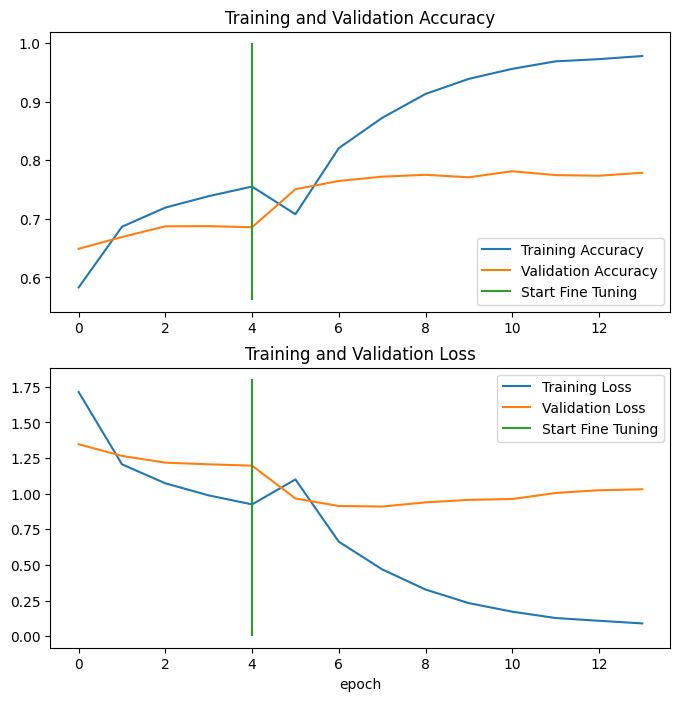

In [29]:
from helper_functions import compare_historys

compare_historys(history_EfficientNetV2B0, history_EfficientNetV2B0_fine_tuning, 5)

1/1 [==============================] - 0s 128ms/step


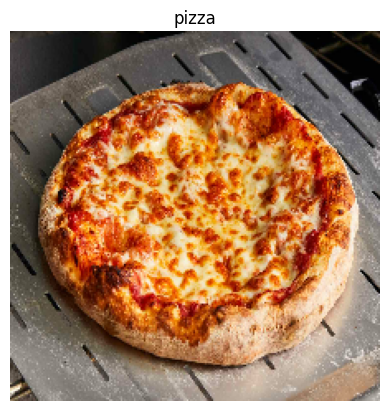

In [41]:
from helper_functions import load_and_prep_image
img = load_and_prep_image('pizza.jpg', img_shape=224, scale=False)
pred = model.predict(tf.expand_dims(img,axis = 0))
pred_class = class_names[pred.argmax()]

plt.figure()
plt.imshow(img / 255)
plt.title(pred_class)
plt.axis(False);